In [1]:
%env TF_CPP_MIN_LOG_LEVEL=3
import sys
from dataclasses import dataclass
import random as r
from functools import partial
from matplotlib import pyplot as plt

import jax
from jax import Array, numpy as jnp, random as jrand
import keras as nn
nn.utils.set_random_seed(42); nn.mixed_precision.set_dtype_policy("mixed_float16")
import tensorflow as tf; tf.config.set_visible_devices([], 'GPU')
tf.random.set_seed(42)

print("Python Version", sys.version); del sys
print(f"Keras Version {nn.__version__} with {nn.backend.backend()} backend \tJax Version {jax.__version__}")
print("Jax backend device", jax.default_backend())

env: TF_CPP_MIN_LOG_LEVEL=3
Python Version 3.11.7 (main, Dec  8 2023, 18:56:58) [GCC 11.4.0]
Keras Version 3.0.4 with jax backend 	Jax Version 0.4.23
Jax backend device gpu


# Positional Embeddings

In [2]:
class PositionalEmbedding:
    """```
    Sinusoidal Fixed Positional Embeddings
    Args:
        maxlen:int
        dim:int
    sinusoidal_embeddings: 
        pos_emb: (1, maxlen, dim)
    get_freqs:
        get_freqs: sin_freqs(1, maxlen, 1, dim), cos_freqs(1, maxlen, 1, dim)
    ```"""
    def __init__(self, maxlen:int, dim:int):
        p, i = jnp.meshgrid(jnp.arange(float(maxlen)), jnp.arange(dim/2)*2)
        theta = (p/1e4**(i/dim)).T

        self.pos_emb = jnp.stack([jnp.sin(theta), jnp.cos(theta)], axis=-1)
        self.pos_emb = self.pos_emb.reshape((maxlen, dim))[None] # (1, maxlen, dim)

    def sinusoidal_embeddings(self):
        return self.pos_emb # (1, maxlen, dim)
    
    def get_freqs(self):
        sin_freqs = jnp.repeat(self.pos_emb[..., None, ::2], repeats=2, axis=-1)
        cos_freqs = jnp.repeat(self.pos_emb[..., None, 1::2], repeats=2, axis=-1)
        return sin_freqs, cos_freqs # (1, maxlen, 1, dim), (1, maxlen, 1, dim)

# Attention

In [3]:
class Attention(nn.Layer):
    """```
    Multi-head Attention
    Args:
        causal:bool
        n_heads:int
        d_model:int
        maxlen:int
        dropout_rate:float
    Input:
        x: shape(B, N, d_model)
    Output:
        linear_att_out: shape(B, N, d_model)
    ```"""
    def __init__(
            self,
            causal:bool,
            num_heads:int,
            d_model:int,
            maxlen:int,
            dropout_rate:float,
            **kwargs
    ):
        super().__init__(**kwargs)
        assert d_model % num_heads == 0
        self.causal = causal
        self.num_heads = num_heads
        self.d_model = d_model
        self.dim = self.d_model//num_heads

        self.wq = nn.layers.Dense(self.d_model, use_bias=False)
        self.wk = nn.layers.Dense(self.d_model, use_bias=False)
        self.wv = nn.layers.Dense(self.d_model, use_bias=False)
        self.attwei_dropout = nn.layers.Dropout(dropout_rate)

        self.w = nn.layers.Dense(d_model)
        if causal:
            self.causal_mask = jnp.triu(jnp.full(shape=(1, 1, maxlen, maxlen), fill_value=-jnp.inf), k=1)

    def call(
            self,
            x:Array, # (B, T, d_model)
            training:bool
    ):
        B, T = x.shape[:-1]

        # compute q, k, v
        q = self.wq(x) # (B, T, d_model)
        k = self.wk(x) # (B, T, d_model)
        v = self.wv(x) # (B, T, d_model)

        # seperate heads
        q = q.reshape((B, self.num_heads, T, self.dim)) # (B, h, T, dim)
        k = k.reshape((B, self.num_heads, T, self.dim)) # (B, h, T, dim)
        v = v.reshape((B, self.num_heads, T, self.dim)) # (B, h, T, dim)

        # compute attention weights
        att_wei = (q @ k.transpose((0, 1, 3, 2)))/self.dim**0.5 # (B, h, T, T) <= (B, h, T, dim) @ (B, h, T, dim).transpose(2, 3)
        if self.causal:
            att_wei = att_wei + self.causal_mask[:, :, :T, :T] # (B, h, T, T)

        att_wei = jax.nn.softmax(att_wei, axis=-1) # (B, h, T, T)
        att_wei = self.attwei_dropout(att_wei, training=training)

        # apply attention weights to v
        att_out = att_wei @ v # (B, h, T, T) @ (B, h, T, dv) => (B, h, T, dv)
        # combine heads
        att_out = att_out.reshape((B, T, self.d_model)) # (B, T, h*dv) ==> (B, T, d_model)

        # linear of att_out
        linear_att_out = self.w(att_out) # (B, T, d_model)
        return linear_att_out

# GPT

In [4]:
def build_model(model:nn.Model, input_shape:tuple, val_intervals:tuple):
    blabla = model(
        jrand.randint(jrand.PRNGKey(32344), shape=input_shape, minval=val_intervals[0], maxval=val_intervals[-1]), training=True
    ); del blabla
    return model


class TieWeights(nn.Layer):
    def __init__(self, dense:nn.Layer, output_units:int,  activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense # (1, vocab_size, d_model)
        self.activation = nn.layers.Activation(nn.activations.get(activation), dtype=kwargs["dtype"])
        self.bias = self.add_weight(shape=(output_units,), initializer="zeros", trainable=True)
        
    def call(self, x): # (B, T, d_model)
        W = jnp.array(self.dense.weights)[0].T # (d_model, vocab_size)
        return self.activation(x @ W + self.bias)


class Block(nn.Model):
    """```
    Block
    Args:
        causal:bool
        num_heads:int
        d_model:int
        maxlen:int
        dropout_rate:float
        use_bias:bool
    Inputs: 
        inputs: shape(B, T, d_model)
        pad_mask: shape(B, T) of boolean dtype
    Outputs:
        outputs: shape(B, T, d_model)
    ```"""
    def __init__(
            self, 
            causal: bool, 
            num_heads: int, 
            d_model: int,
            maxlen:int,
            dropout_rate: float,
            **kwargs
    ):
        super().__init__(**kwargs)
        dff_in = 4*d_model
        self.norm1 = nn.layers.LayerNormalization(epsilon=1e-5)
        self.norm2 = nn.layers.LayerNormalization(epsilon=1e-5)

        self.mha = Attention(causal, num_heads, d_model, maxlen, dropout_rate)

        self.ffn = nn.Sequential([
            nn.layers.Dense(int(dff_in), use_bias=True),
            nn.layers.Activation(nn.activations.gelu),
            nn.layers.Dense(d_model, use_bias=True),
            nn.layers.Dropout(dropout_rate)
        ])
        
    def call(self, x:Array, training:bool):
        z = x + self.mha(self.norm1(x), training=training)
        y = z + self.ffn(self.norm2(z), training=training)
        return y # (B, T, d_model)

In [5]:
class GPT(nn.Model):
    """```
    GPT!!
    Args:
        args:
            d_model: int
            num_heads: int
            num_layers: int
            max_context_length: int
            vocab_size: int
            output_units: int => if None is equal to vocab_size
            dropout_rate: float
        causal:bool
        output_activation:str
    Inputs:
        inputs: shape(B, T)
    Outputs: 
        outputs: shape(B, T, d_model)    
    ```"""
    def __init__(self, args, causal:bool, output_activation:str=None, **kwargs):
        super().__init__(**kwargs)
        if args.output_units is None:
            args.output_units = args.vocab_size
        # pos embedding
        self.pos_embed = PositionalEmbedding(args.max_context_length, args.d_model).sinusoidal_embeddings() # (1, maxlen, d_model)
        # embedding tokens and dropout
        self.emb_dropout = nn.layers.Dropout(args.dropout_rate)
        self.token_embed = nn.layers.Embedding(args.vocab_size, args.d_model)

        # block layers
        self.block_layers = [
                Block(
                    causal=causal, 
                    num_heads=args.num_heads,
                    d_model=args.d_model,
                    maxlen=args.max_context_length,
                    dropout_rate=args.dropout_rate,
                ) for _ in range(args.num_layers)
            ]

        # final layer: outputs logits with dropout
        self.norm = nn.layers.LayerNormalization(epsilon=1e-5)
            # nn.layers.Dense(args.output_units, activation=output_activation, use_bias=True)
        self.linear = TieWeights(self.token_embed, args.output_units, activation=output_activation, dtype="float32")
        self.logits_dropout = nn.layers.Dropout(rate=args.dropout_rate)

    def call(
            self, 
            inputs:Array,
            training=False
    ):
        # embed tokens
        x = self.emb_dropout(
            self.token_embed(inputs)+self.pos_embed[:, :inputs.shape[-1], :], training=training
        ) # (B, T) ==> (B, T, d_model) # (B, T) ==> (B, T, d_model)
        
        # block layers
        for layer in self.block_layers:
            x = layer(x, training=training) # (B, T, d_model) ==> (B, T, d_model)
        x = self.norm(x)

        # linear layer: outputs logits
        logits = self.linear(x) # (B, T, d_model) ==> (B, T, vocab_size)
        return self.logits_dropout(logits)

# Dataset

In [6]:
shakespeare_url = "https://homl.info/shakespeare"
filepath = nn.utils.get_file("shakespeare.txt", shakespeare_url)
shakespeare_text = open(filepath, "r", encoding="utf-8").read()

In [7]:
print(shakespeare_text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [8]:
chars = sorted(list(set(shakespeare_text)))
VOCAB_SIZE = len(chars)
print(''.join(chars))
print(VOCAB_SIZE)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [9]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(1_000_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [10]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

print(encode(shakespeare_text[:100]))
print(decode(encode(shakespeare_text[:100])))

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43, 43, 42, 1, 39, 52, 63, 1, 44, 59, 56, 58, 46, 43, 56, 6, 1, 46, 43, 39, 56, 1, 51, 43, 1, 57, 54, 43, 39, 49, 8, 0, 0, 13, 50, 50, 10, 0, 31, 54, 43, 39, 49, 6, 1, 57, 54, 43, 39, 49, 8, 0, 0, 18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 37, 53, 59]
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


# GPT Args

In [11]:
@dataclass
class GPTArgs:
    """GPT Configuration"""
    d_model:int = 288
    num_layers:int = 6
    num_heads:int = 6
    max_context_length:int = 256
    vocab_size:int = VOCAB_SIZE
    output_units:int = None
    assert d_model % 2 == 0
    assert d_model % num_heads == 0
    dropout_rate:float = 0.4

GPTArgs()

GPTArgs(d_model=288, num_layers=6, num_heads=6, max_context_length=256, vocab_size=65, output_units=None, dropout_rate=0.4)

In [12]:
model = GPT(GPTArgs, causal=True)
model = build_model(model, (2, GPTArgs.max_context_length), [0, GPTArgs.vocab_size-1])
model.summary()

Model: "gpt"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ embedding (Embedding)           │ ?                         │     18,720 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block (Block)                   │ ?                         │    997,632 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_1 (Block)                 │ ?                         │    997,632 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_2 (Block)                 │ ?                         │    997,632 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_3 (Block)                 │ ?                         │    997,632 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_4 (Block)                 │ ?                         │    997,632 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_5 (Block)                 │ ?                         │    997,632 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ layer_normalization_12          │ ?                         │        288 │
│ (LayerNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ tie_weights (TieWeights)        │ ?                         │     18,785 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_13 (Dropout)            │ ?                         │          0 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,004,865 (22.91 MB)

 Trainable params: 6,004,865 (22.91 MB)

 Non-trainable params: 0 (0.00 B)

# Loss Vs LR

```python
def LossvsLR(): # (B, maxlen)
    model = build_model(
        GPT(GPTArgs, causal=True, ), 
        (2, GPTArgs.max_context_length), 
        (0, GPTArgs.vocab_size-1)
        )
    inputs = jrand.randint(jrand.PRNGKey(32344), shape=(2, GPTArgs.max_context_length+1), minval=0, maxval=GPTArgs.vocab_size-1)

    def get_loss(lr, model, inputs):
        x, y = inputs[:, :-1], inputs[:, 1:]
        model.compile(
            optimizer=nn.optimizers.AdamW(
                learning_rate=lr, beta_1=0.9, beta_2=0.99, clipvalue=1e0, weight_decay=1e-1),
            loss=nn.losses.SparseCategoricalCrossentropy(from_logits=True)
        )
        loss = model.train_on_batch(x=x, y=y)
        return loss.tolist()
    
    lrs = (10**jnp.linspace(-6, -2, 100)).tolist()
    losses = [get_loss(lr, model, inputs) for lr in lrs]
    # losses = jax.vmap(get_loss, in_axes=(None, 0))(model, lrs)
    return lrs, losses

lr, loss = LossvsLR()

plt.figure(figsize=(15,10))
plt.xlabel("Learning Rate: 10^(x) to get actual learning rate")
plt.ylabel("Loss")
plt.xticks([-6, -5, -4]+jnp.arange(-3.5, -2.8, 0.1).tolist())
plt.plot(jnp.log10(jnp.array(lr)), loss)
plt.show()
```

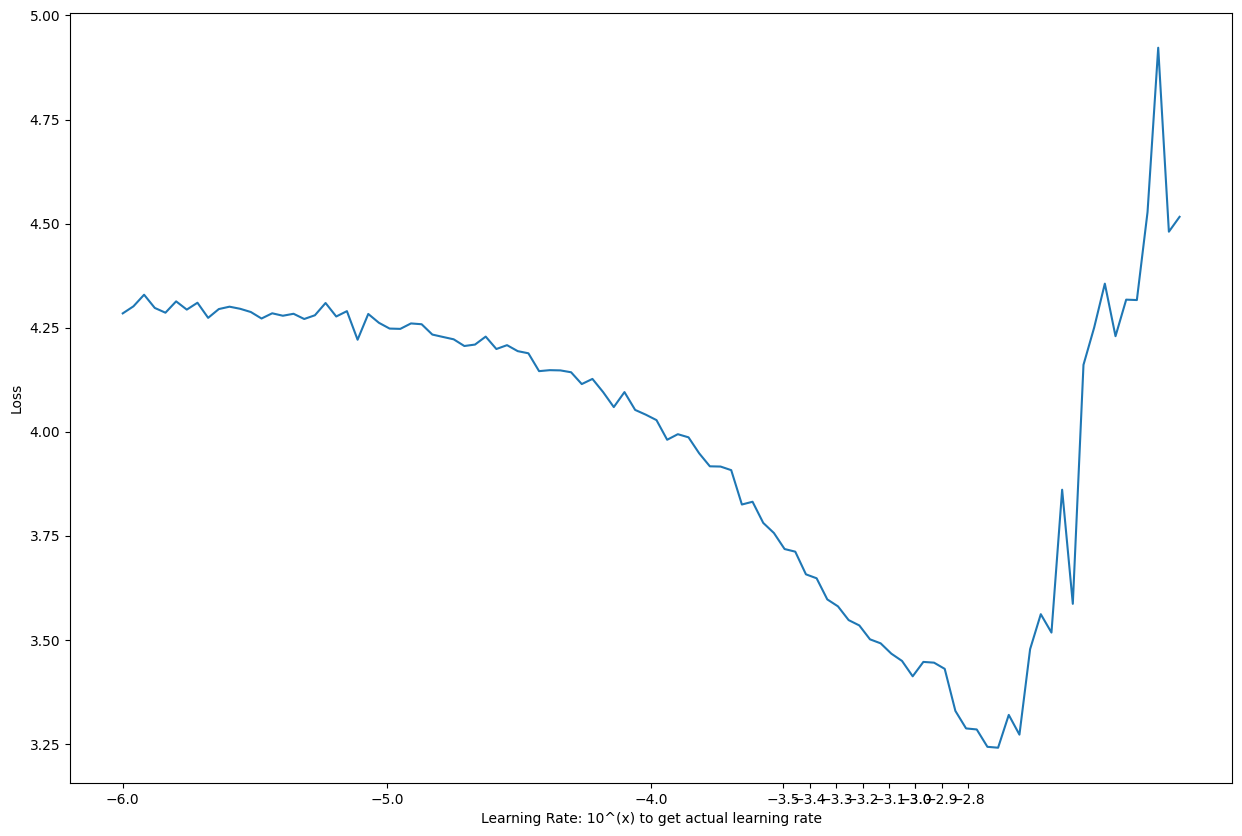

# Training Arguments

In [19]:
@dataclass
class TArgs:
    "Training Arguments"
    checkpoint:str = "weights/gpt_shakespeare1/Epoch{epoch}.weights.h5"
    steps_per_epoch:int = 250
    patience:int = 10 # was 20, changed to 10
    
    batch_size:int = 128
    num_steps:int = 50_000 # very very much more than enough, but early stopping with restore best weights for rescue!
    epochs:int = num_steps//steps_per_epoch

    init_lr:float = 1e-7
    max_lr:float = 8.5e-4
    min_lr:float = 0.1*max_lr
    warmup_steps:int = 500
    decay_steps:int = num_steps

    beta1:float = 0.9
    beta2:float = 0.99
    clipvalue:float = 1e0
    weight_decay:float = 1e-1
    num_grad_accumalation_steps:int = 4

In [20]:
data = encode(shakespeare_text)
datasets = {"train": to_dataset(data[:1_000_000], length=GPTArgs.max_context_length, shuffle=True, batch_size=TArgs.batch_size, seed=42).repeat(5).shuffle(10000), # ~90%split
            "val": to_dataset(data[1_000_000:], length=GPTArgs.max_context_length, shuffle=True, batch_size=TArgs.batch_size, seed=0)}
print(datasets)

{'train': <_ShuffleDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>, 'val': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>}


# Model, lr schedule, compile and training

In [21]:
learning_rate = nn.optimizers.schedules.CosineDecay(
    initial_learning_rate=TArgs.min_lr,
    decay_steps=TArgs.decay_steps,
    warmup_steps=TArgs.warmup_steps,
    warmup_target=TArgs.max_lr,
    alpha=TArgs.min_lr/TArgs.max_lr
)

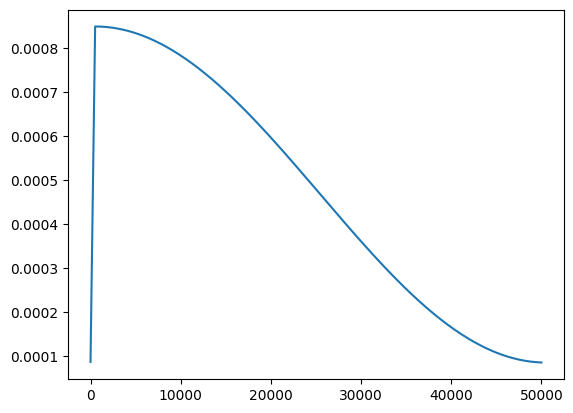

In [22]:
steps = jnp.arange(1, TArgs.num_steps+1)
lrs = jax.vmap(learning_rate)(steps)

plt.plot(steps, lrs); del lrs, steps
plt.show()

In [23]:
model.compile(
    optimizer=nn.optimizers.AdamW(
        learning_rate=learning_rate,
        beta_1=TArgs.beta1,
        beta_2=TArgs.beta2, 
        clipvalue=TArgs.clipvalue, 
        weight_decay=TArgs.weight_decay,
        gradient_accumulation_steps=TArgs.num_grad_accumalation_steps
    ),
    loss=nn.losses.SparseCategoricalCrossentropy(from_logits=True),
)

In [24]:
saveW = nn.callbacks.ModelCheckpoint(
    filepath=TArgs.checkpoint,
    save_weights_only=True,
    save_best_only=True
)
early_stop = nn.callbacks.EarlyStopping(
    patience=TArgs.patience,
    restore_best_weights=True,
    verbose=1
)

In [25]:
history = model.fit(
    x=datasets["train"],
    epochs=TArgs.epochs, # 45, # Lowest Loss obtained at epoch 45 with val_loss 1.4790
    steps_per_epoch=TArgs.steps_per_epoch,
    validation_data=datasets["val"],
    callbacks=[saveW, early_stop]
) # ~35mins

Epoch 1/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 168ms/step - loss: 3.6015 - val_loss: 3.3479
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - loss: 3.3128 - val_loss: 3.3446
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 151ms/step - loss: 3.3039 - val_loss: 3.1411
Epoch 4/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 153ms/step - loss: 3.0385 - val_loss: 2.7416
Epoch 5/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 154ms/step - loss: 2.6679 - val_loss: 2.4432
Epoch 6/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - loss: 2.4431 - val_loss: 2.2844
Epoch 7/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - loss: 2.2880 - val_loss: 2.1311
Epoch 8/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step - loss: 2.1551 - val_loss: 2.0063
Epoch 9/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - loss: 2.0200 - val_loss: 1.9227
Epoch 10/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - loss: 1.9056 - val_loss: 1.8585
Epoch 11/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - loss: 1.8136 - val_loss: 1.8047
Epoch 12

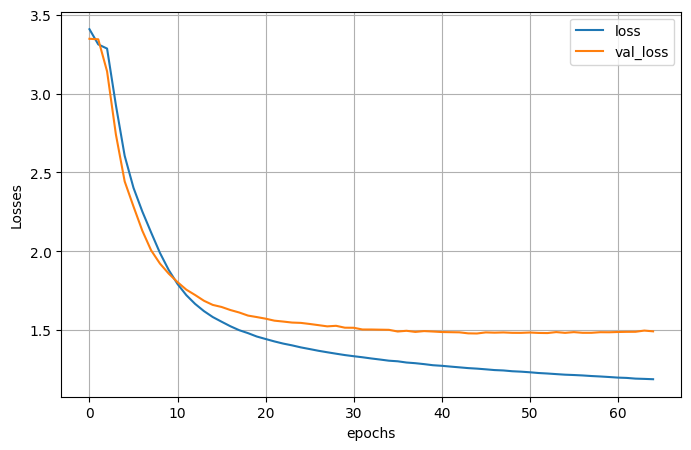

In [26]:
from pandas import DataFrame
df = DataFrame({key:value for key, value in history.history.items() if key in ["loss", "val_loss"]})
df.plot(figsize=(8, 5), grid=True, xlabel="epochs", ylabel="Losses");

# Generate Predictions

In [27]:
def sample_top_k(key, logits, k):
    topk_logits, topk_idx = jax.lax.top_k(logits, k=k)
    idx = jrand.categorical(key, topk_logits)
    return topk_idx[0][idx]

def generate(idx:Array, max_new_tokens:int, top_k:int|None=None, seed:int=42):    
    key = jrand.PRNGKey(seed)
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -GPTArgs.max_context_length:] # (B, T)
        logits = model(idx_cond, training=False)[:, -1, :]/0.8 # (B, T, vocab_size)[:, -1, :] => (B, vocab_size)
        idx_next = jrand.categorical(key, logits) if top_k is None else sample_top_k(key, logits, k=top_k) # (T=1,)
        key, _ = jrand.split(key)
        idx = jnp.concatenate((idx, idx_next[None]), axis=-1) # (B, T+1)
    return idx.tolist()[0]

In [28]:
print(decode(generate(idx=jnp.array([[0]]), max_new_tokens=4000, seed=42, top_k=None))) # random categorical sampling # ~11.5mins


AULI sence,

QUE:
Thing Edward?

DUKE VINCENTIO:
The son, which not to his telless
I a menn hacupy then you razel now.

Provost:
Heedin way, Pe wocatering for thibutation.

Ges, fonales hot was s aly,
As presen of grineld blamitestist blest gs,
Gles, nor in the silver than the man afford,
And the tepken of your name and loathsome sweets,
And I received thee proclaim the day to the day,
For love, tell my lady little, sir, if you be less.

KING RICHARD II:
The pleasing shall be true? O lord, thou delay'st
For pair with so sweet speech: and why she hath bid them not.

RICHARD:
Shall I meet thee on you should pluck a blame
Of the duke will go wonder.

CORIOLANUS:
Come, cousin!

HERMIONE:
Brother, better than bitter, and you are rule in his
terrorious character, therefore shall after for him,
Many eyes of this ancient to his country:
And ere they scarce to possession,
As from me thy blood master good will you once ear.

GLOUCESTER:
Thou shalt do it please your grace.

CLARENCE:
What's the 

In [29]:
print(decode(generate(idx=jnp.array([[0]]), max_new_tokens=4000, seed=98857745, top_k=10))) # tok-10 random categorical sampling # ~6.5mins


USAK:
Sin your hath speals,
And that suns
Things are slaughter the
contrationg tral,
I alll shocok up so blabet,
With a scape fort oucke wale,
An tink, wither of welcomed wante
Bage
Bomomes ts abry, ischarge ale alive bon,
Autese ptin tentas t s temint.

LADY CAPULET:
As they are the proceeded fools,
And live to hear him to stay.

DUKE VINCENTIO:
O, my lord, I hold thee hither must be true
And the wisest strange of state in my sad,
Sir Richard Capulet: I will be a purerused.

GLOUCESTER:
And many that comes as many grave as we,
The more idle silence for his foot.

LORD ROSS:
Are it friends my mother, whom in the summer was worn:
My brother Greece! had you a man of man's extremes
To call you and to see him and the son,
If not heavy doth change them to see him for
the poor demands for second with the face,
When I part that thou hast not speak of strength,
And all the mother as we are the which is the milty
of those side by that made to the present than
your former with the thief to be h

In [30]:
print(decode(generate(idx=jnp.array([[0]]), max_new_tokens=4000, seed=12212, top_k=5))) # tok-5 random categorical sampling # ~7mins


USAMI had ned in a man thy should bot this be
A creature sets. If
He will not hish.

To loploss:
I shape to be too blest.

CAPULETES:
EESBY:
ER:
LETESET:
Weep of Edward's willlles, fus fus;
Ty ioum inite the costard ones om, t atage
Auste wabate wasinal and
The soldiers of the draw of days with me and
As that thou shalt not pay to some others;
But I will part to-day, and my liege,
And many as the postern of his charge.

DUKE VINCENTIO:
He will, sir.

Provost:
Well, thou art patient, and they were, brother,
So may be so brief, that we want, if thou hast not
seat of the day of something strew'd up the bows
And beating of my boots are at the princely bless,
But if thou hast stood with the marriage of thee!

RICHMOND:
Why, what a man as much as as thou set on.

KING EDWARD IV:
But what's the princes of me, and they shall pardon thee,
And, as the part in all power of this deeds
Of my sweet boys before I cannot do't;
And so her fair a person of your chamber,
The presently gods have more pri

In [31]:
print(decode(generate(idx=jnp.array([[0]]), max_new_tokens=4000, seed=4357, top_k=25))) # tok-7 random categorical sampling # ~7mins


oursely, a ever
'Tis of the
secut where was
Which thou wilt do thee,
My calls uttles mede,
Thus means to what say she
shall be twhery fus, bonelonted: beingted baits,
All ike us wine mande me demin to Romeo?

BRUTUS:
Way:
NORUS:
Deesusustomeecay:
Waterus, my lord.

HERMIONE:
Then, and stay, for the man;
What says he is not that seems to him?

FRIAR LAURENCE:
O thou art a prettiest bastards, and the sents,
Or the town.

CORIOLANUS:
Content to what you should wrath.

ISABELLA:
What says the gates of the state,
And I'll prove thee to be the death.

CAPULET:
Thou shalt poison unto the deputy of the queen!

First Senator:
Come hither, we will prove him mockery true balm;
And for them then to say 'God and grief.

ESCALUS:
Why, so? haste, live in my love, and then lies much
As hither to bear them for the two
of the hollow hath gold still wear the show
Of nights and with me for a prosperous place.

ROMEO:
It is, my lord.

KING RICHARD III:
No; I will be in this cheap sparing yet;
If when you 

In [32]:
print(decode(generate(idx=jnp.array([[0]]), max_new_tokens=4000, seed=2354732, top_k=45))) # tok-45 random categorical sampling # ~6.5mins


ELARI chare.

Sent, my wife
I sham, whe saides,
That I have seen, such erre
ins hind shagalot
Tis a balm to me as much
By suspiciouse te iontet on:
Ined as mine woman's nowne, bres.
De mat dededeshed air home, I have, lenentishene tent wantinenont.
hering of my strong, and you shall about your life.

ROMEO:
What sorrow is not the king and thou of the sea,
For the benefit of warms and lead of call age,
Or in the dead friends of the breast,
And thou knowing whose idle proper of Coriolanus
As determined us, and by him out of a sweetest sea,
As they say they set down in any close.

CORIOLANUS:
Lates, one of me!

PRINCE EDWARD:
Welcome, your wits and young place from departure.

GLOUCESTER:
Ay, much better than my most business in her.

LUCIO:
I will well seem warm, with me the care,
Methinks not so well as any honesty:
So well as they have all unto your honour:
But I, in the sun, thou wilt say he shall prove them.

CAPULET:
Menenius, father's dead, and thoughts the uncle,
But seems are me

In [33]:
print(decode(generate(idx=jnp.array([[0]]), max_new_tokens=500, seed=2354732, top_k=1))) # Greedy Sampling ahhhh bad # ~3.716666667mins
# Compare with the above, and see the difference, sampling technique matters!!!


I the shoon ther the
shout to bearry.

KING RICHARD III:
What is the strampedies
Aue thantie tend the air oful day.

KING RICHARD IORD LARDOHARDARD IINRE:
Was nothing bless at ble ble bombombras,
Aneft the sea of thearrmonithe ale mottte,
amoon'sh thatt the sea of the sea,
And therefore are the season of the sea,
And therefore are the season of the sea,
And therefore are the season of the sea,
And therefore are the season of the sea,
And therefore are the season of the sea,
And therefore are the
